In [6]:
import os
import numpy as np
import pandas as pd
import open3d as o3d
from glob import glob
import logging
import matplotlib.pyplot as plt 

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def create_transects_around_target_theta2(df, target_theta2_values, theta_range=1):
    transects = []
    for target_theta2 in target_theta2_values:
        transect = df[(df['theta'] >= target_theta2 - theta_range) & (df['theta'] <= target_theta2 + theta_range)]
        transects.append(transect)
    return transects

def check_unassigned_points(df, transects):
    assigned_points = pd.concat(transects)
    unassigned_points = df[~df.index.isin(assigned_points.index)]
    return len(unassigned_points)

def process_pcd_file(file_path, transformation_matrix, target_theta2_values):
    try:
        # Load point cloud
        pcd = o3d.io.read_point_cloud(file_path)
        xyz = np.asarray(pcd.points)
        
        # Convert to spherical coordinates
        x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
        rho = np.sqrt(x**2 + y**2 + z**2)
        theta_degrees = np.degrees(np.arccos(z / rho))
        
        # Create DataFrame
        point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})
        
        # Generate transects
        transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=1)
        unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
        if unassigned_points_count > 0:
            logging.warning(f"Unassigned points count: {unassigned_points_count}")

        # Select Transect_3 for transformation
        transect_A = transects[2].drop(columns=['theta'])
        transect_xyz = transect_A[['x', 'y', 'z']].values
        
        # Apply transformations
        transect_transformed_df = apply_transformations(transect_xyz, transformation_matrix)
        
        # Extract timestamp from filename
        timestamp = os.path.basename(file_path)[-21:-4]
        transect_transformed_df['timestamp'] = timestamp
        
        return transect_transformed_df
    except Exception as e:
        logging.error(f"Error processing file {file_path}: {e}")
        return pd.DataFrame(columns=['timestamp', 'x', 'y', 'z'])

def apply_transformations(transect_xyz, transformation_matrix):
    try:
        # Apply the initial transformation matrix
        transect_xyz_homogeneous = np.hstack((transect_xyz, np.ones((transect_xyz.shape[0], 1))))
        transect_xyz_transformed = transect_xyz_homogeneous.dot(transformation_matrix.T)[:, :3]

        ### place to add external points (lidar drone or GPS) ###
        
        # Compute the translation back offsets for X and Y only
        translation_back = np.eye(4)
        translation_back[0, 3] = -transformation_matrix[0, 3]
        translation_back[1, 3] = -transformation_matrix[1, 3]
        
        # Apply the translation back to the origin for X and Y
        transect_xyz_homogeneous = np.hstack((transect_xyz_transformed, np.ones((transect_xyz_transformed.shape[0], 1))))
        transect_xyz_transformed = transect_xyz_homogeneous.dot(translation_back.T)[:, :3]
        
        # Extract the rotation angle around the Z-axis
        theta_z = np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0])
        
        # Create a reverse rotation matrix for the Z-axis
        cos_theta_z = np.cos(theta_z)
        sin_theta_z = np.sin(theta_z)
        rotation_z_matrix = np.array([
            [cos_theta_z, -sin_theta_z, 0, 0],
            [sin_theta_z, cos_theta_z,  0, 0],
            [0,           0,            1, 0],
            [0,           0,            0, 1]
        ])
        
        # Apply the reverse rotation around the Z-axis
        transect_xyz_homogeneous = np.hstack((transect_xyz_transformed, np.ones((transect_xyz_transformed.shape[0], 1))))
        transect_xyz_transformed = transect_xyz_homogeneous.dot(rotation_z_matrix.T)[:, :3]
        
        return pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])
    except Exception as e:
        logging.error(f"Error applying transformations: {e}")
        return pd.DataFrame(columns=['x', 'y', 'z'])

def main(transformation_matrix, output_csv_name, pcd_directory):
    target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]
    
    all_transformed_data = pd.DataFrame(columns=['timestamp', 'x', 'y', 'z'])
    
    pcd_files = glob(os.path.join(pcd_directory, "*.PCD"))
    if not pcd_files:
        logging.info("No .PCD files found in the specified directory.")
    else:
        for file_path in pcd_files:
            logging.info(f'Processing file: {file_path}')
            transformed_data = process_pcd_file(file_path, transformation_matrix, target_theta2_values)
            all_transformed_data = pd.concat([all_transformed_data, transformed_data], ignore_index=True)
    
        output_csv_path = os.path.join(pcd_directory, output_csv_name)
        all_transformed_data.to_csv(output_csv_path, index=False)
        logging.info(f"All transformed data saved to: {output_csv_path}")




In [7]:
if __name__ == "__main__":
    # Define the transformation matrix
    transformation_matrix = np.array([
        [2.9116514e-05, 0.000371316622, -0.0009284431, (644.85302734375 + 85000)],
        [-1.1219916e-05, -0.000928656838, -0.000371753966, (992.743286132813 + 445000)],
        [-0.000999878626, 2.123348e-05, -2.2864835e-05, 0.827817559242],
        [0.0, 0.0, 0.0, 1.0]
    ])
    pcd_directory = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Lidar\Alignment_test\Test"
    output_csv_name = 'test_1970_00_41.csv'
    main(transformation_matrix, output_csv_name, pcd_directory)

2024-11-29 11:29:41,888 - INFO - Processing file: C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Lidar\Alignment_test\Test\HybridDune_Pcl_0001_01_1970__00_47_03.459.PCD
C:\Users\ruro\AppData\Local\Temp\ipykernel_10928\1934305957.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_transformed_data = pd.concat([all_transformed_data, transformed_data], ignore_index=True)
2024-11-29 11:29:41,904 - INFO - Processing file: C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Lidar\Alignment_test\Test\HybridDune_Pcl_0001_01_1970__00_47_03.709.PCD
2024-11-29 11:29:41,928 - INFO - Processing file: C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Lidar\Alignment_test\Test\HybridDune_Pcl_0001_01_1970__0

C:\Users\ruro\AppData\Local\Temp\ipykernel_10928\3927662603.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', (len(unique_timestamps) // x)+1)


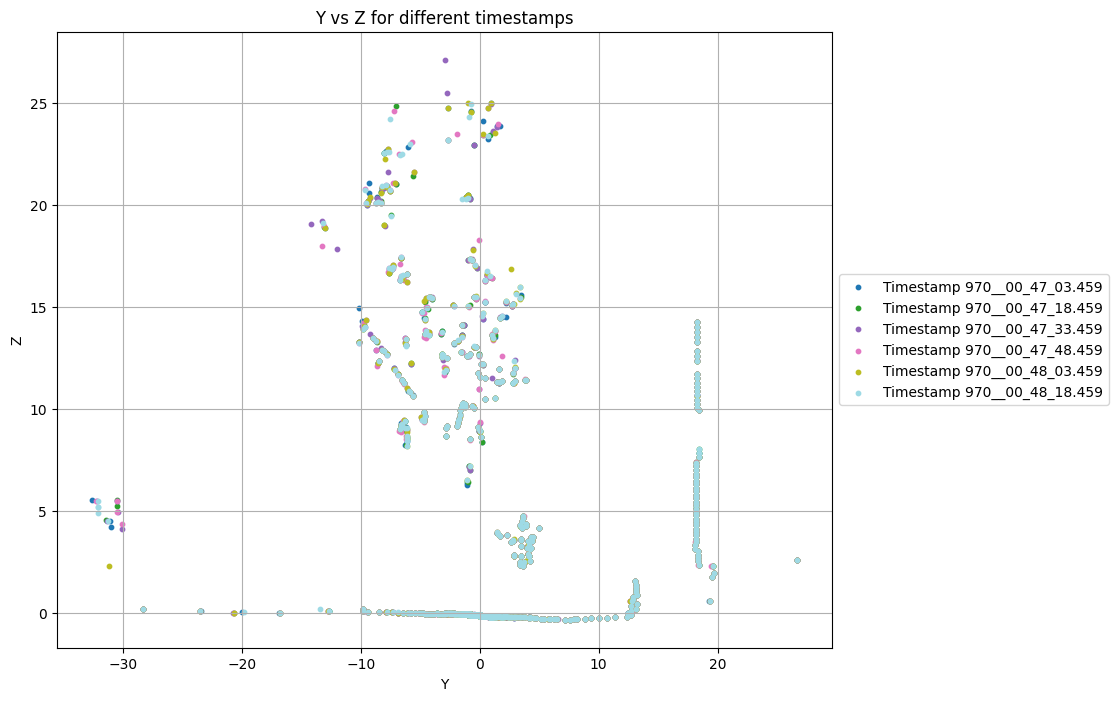

In [8]:
# Variable holding the file path of the CSV file
csv_file_path = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Lidar\Alignment_test\Test\test_1970_00_41.csv"

df = pd.read_csv(csv_file_path)

# Extract unique timestamps
unique_timestamps = df['timestamp'].unique()

## sampling rate ##
x = 60 


# Get a colormap with a number of colors equal to the number of unique timestamps divided by x
colors = plt.cm.get_cmap('tab20', (len(unique_timestamps) // x)+1)

plt.figure(figsize=(10, 8))

# Loop through every xth unique timestamp
for i, timestamp in enumerate(unique_timestamps[::x]):
    filtered_data = df[df['timestamp'] == timestamp]
    plt.scatter(filtered_data['y'], filtered_data['z'], color=colors(i), label=f'Timestamp {timestamp}', s=10)

plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Y vs Z for different timestamps')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend outside on the right)
plt.show();

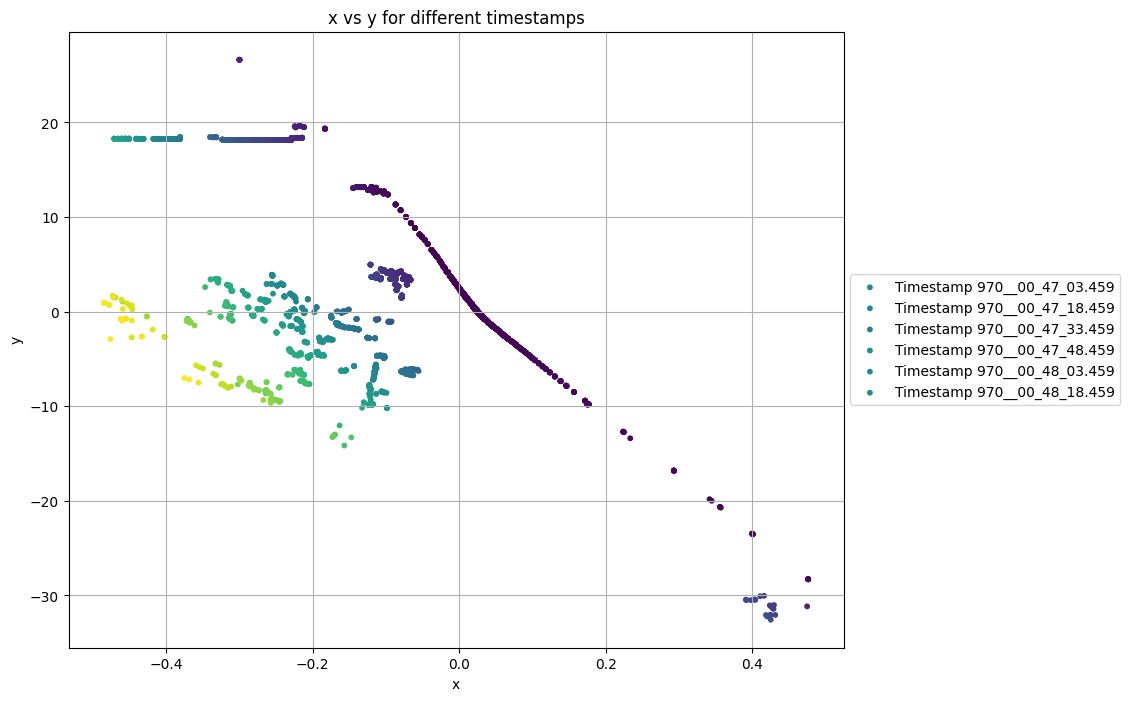

In [9]:
plt.figure(figsize=(10, 8))

# Loop through every xth unique timestamp
for i, timestamp in enumerate(unique_timestamps[::x]):
    filtered_data = df[df['timestamp'] == timestamp]
    plt.scatter(filtered_data['x'], filtered_data['y'], c=filtered_data['z'], label=f'Timestamp {timestamp}', s=10)

plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y for different timestamps')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend outside on the right)
# plt.gca().set_aspect('equal', adjustable='box')
plt.show();

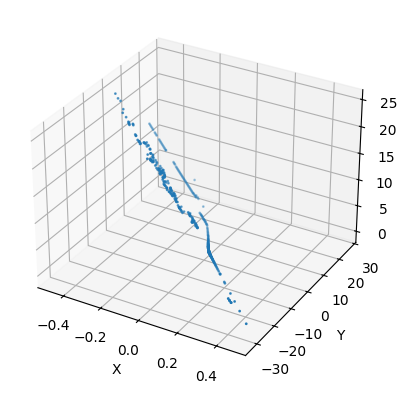

In [10]:
# # Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered_data['x'], filtered_data['y'], filtered_data['z'], s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show plot
plt.show()